In [97]:
import fastf1 as ff1
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
ff1.Cache.enable_cache('../cache')

pd.options.mode.chained_assignment = None
from fastf1 import plotting
plt.style.use('dark_background')

In [98]:
fp = ff1.get_event(2024, 3)

In [99]:
import os

# Set your desired directory path here
directory_path = "./" + str(fp.year) + "/" + fp.Location + "/free_practice"

# Create the directory if it doesn't exist
if not os.path.exists(directory_path):
    os.makedirs(directory_path)
    print(f"Directory '{directory_path}' was created.")
else:
    print(f"Directory '{directory_path}' already exists.")


Directory './2024/Melbourne/free_practice' was created.


In [100]:
p1 = fp.get_practice(1)
p1.load()

p2 = fp.get_practice(2)
p2.load()

p3 = fp.get_practice(3)
p3.load()

core           INFO 	Loading data for Australian Grand Prix - Practice 1 [v3.3.0]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
logger      WARNING 	Failed to load result data from Ergast!
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            IN

In [101]:
def compound_color(compound):
    match compound:
        case 'HARD' : return 'lightgrey'
        case 'MEDIUM' : return 'gold'
        case 'SOFT' : return 'red'

def day_marker(day):
    match day:
        case 1 : return 'o:'
        case 2 : return 'D:'
        case 3 : return 's:'

# Pick out stints of a session
def pick_stints(laps, min_len = 5, quicklaps_threshold = 1.10):
    laps = laps.pick_quicklaps(quicklaps_threshold)
    laps.set_index('LapNumber', inplace=True)
    laps['LapTime'] = [t.total_seconds() for t in laps['LapTime']]
    stints = [x for _, x in laps.groupby(['Stint', 'Driver'])]
    stints = [stint for stint in stints if len(stint) > min_len]
    return stints

def compare_long_runs_deg(day_laps, title, comparison_teams, main_team = 'Alpine', remove_outlier=False, min_laps = 5, file_name = None):
    laps = day_laps
    laps['Color'] = laps['Compound'].apply(compound_color)

    laps = laps.pick_team(main_team)

    stints_1 = pick_stints(laps, min_len= min_laps)

    # remove some eye picked outliers. Gasly's stint is not a long stint but multiple quick laps
    if remove_outlier:
        stints_1 = stints_1[1:]

    plt.figure(figsize=(15, 10))
    plt.title(title)
    ax = plt.subplot()
    ax.grid(zorder=10, alpha=0.2)
    ax.set_xlabel('Laps')
    ax.set_ylabel('Lap time (s)')
    #ax.set_ylim(bottom=94, top=101)
    ax.set_xticks(range(0, 25, 5))

    main_team_label = main_team
    marker = day_marker(1)

    # plot day 1
    for stint in stints_1:
        s = stint.reset_index()
        ax.plot(s.index + 1, s['LapTime'], marker, color = plotting.team_color(main_team), label = main_team_label)
        main_team_label = None

    for team_name in comparison_teams:
        if team_name == main_team:
            continue
        baseline = pick_stints(day_laps.pick_team(team_name), min_len=min_laps)[:1]
        for stint in baseline:
            s = stint.reset_index()
            ax.plot(s.index + 1, s['LapTime'], marker, color=plotting.team_color(team_name), label = team_name)

    plt.legend()
    if file_name != None:
        plt.savefig(directory_path + '/' + file_name, bbox_inches = "tight")
    plt.show()

comparison_teams = sorted(p1.results['TeamName'].unique())

In [102]:
p3.laps.pick_team('Alpine')['Compound'].value_counts()

Compound
SOFT    37
Name: count, dtype: int64

<Axes: xlabel='Laps', ylabel='Lap Time (s)'>

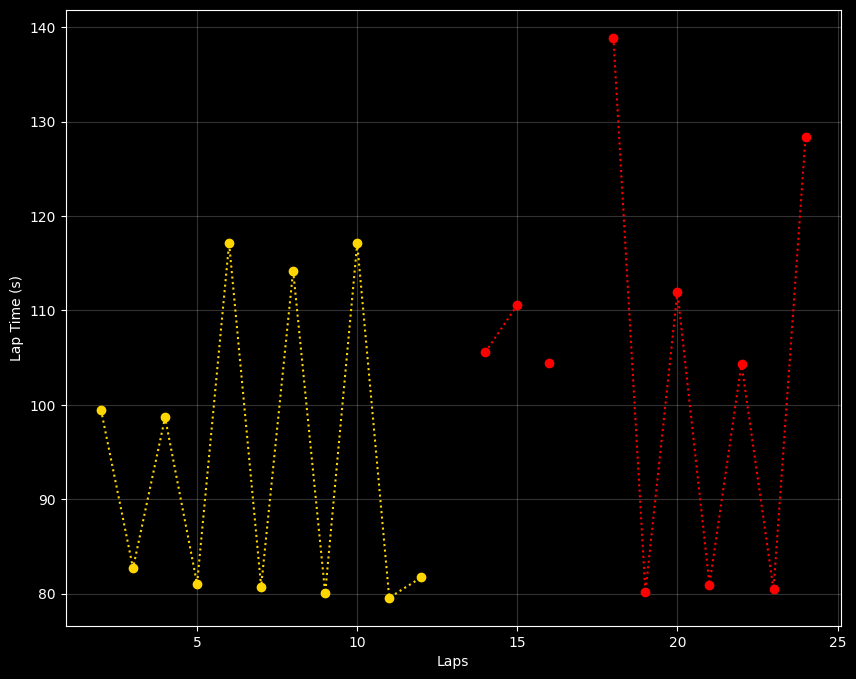

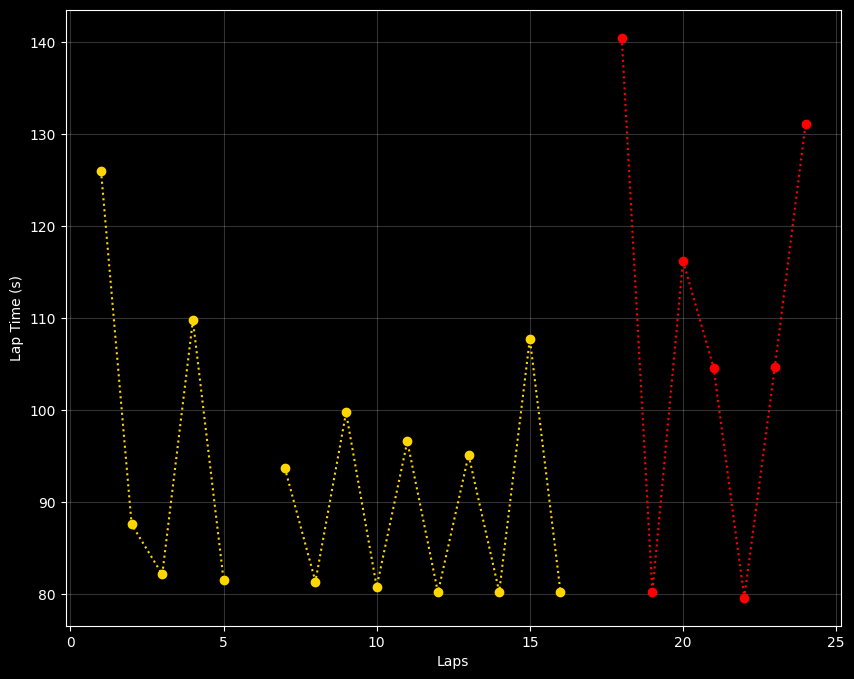

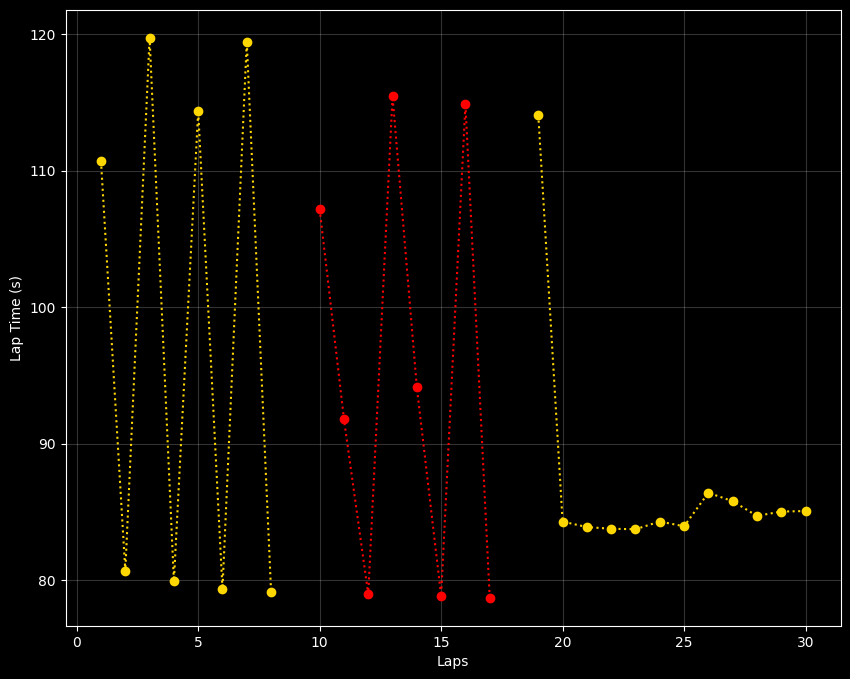

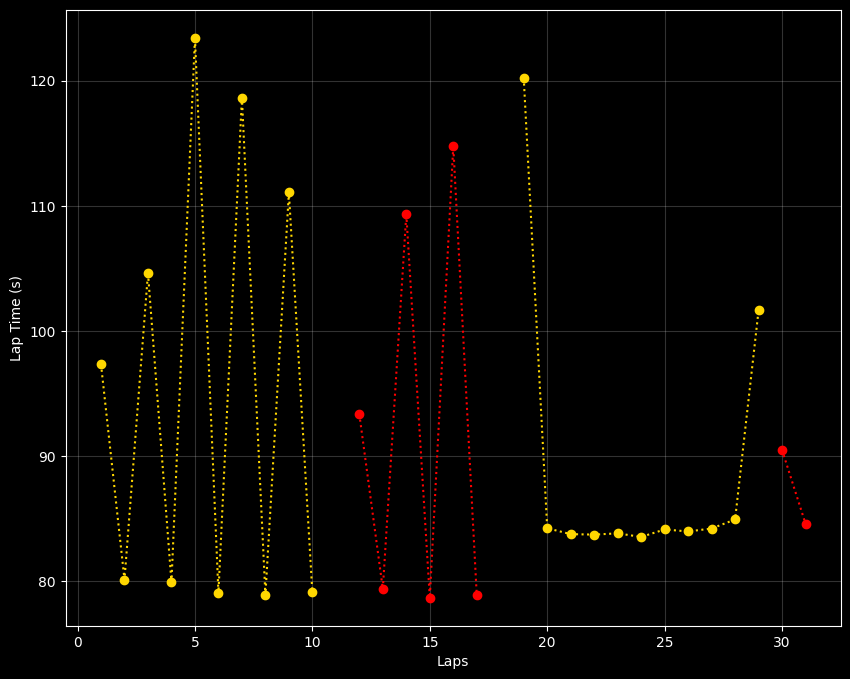

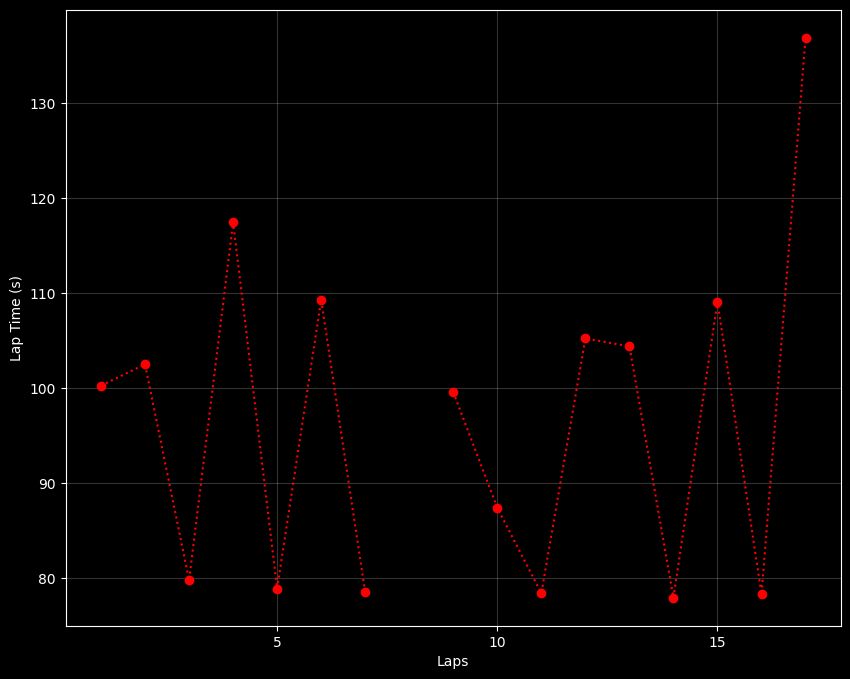

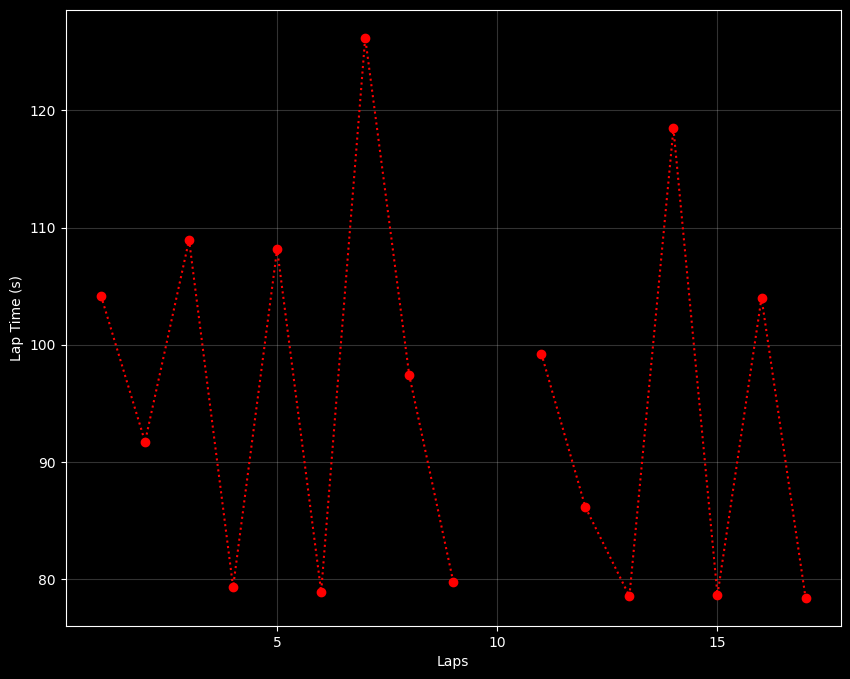

In [103]:
def plot_testing(session, driver, limit=1.30, file_name = None, ax = None, x_labels = True):
    #laps = session.laps.pick_quicklaps(limit)
    laps = session.laps

    ocon_laps = laps[laps['Driver'] == driver]
    ocon_laps.set_index('LapNumber', inplace=True)
    ocon_laps['LapTime'] = [t.total_seconds() for t in ocon_laps['LapTime']]

    ocon_stints = [x for _, x in ocon_laps.groupby('Stint')]
    if ax == None:
        plt.figure(figsize=(10,8))
        ax = plt.subplot()

    max_lap = int(max([s.index.max() for s in ocon_stints]))
    ax.set_xticks(range(0, max_lap + 5, 5))
    c1_label = False
    c2_label = False
    c3_label = False
    for stint in ocon_stints:
        label = 'Hard' if stint['Compound'].iloc[0] == 'HARD' else 'Medium' if stint['Compound'].iloc[0] == 'MEDIUM' else 'Soft'
        match label:
            case 'Hard':
                if c1_label == False:
                    c1_label = True
                else:
                    label = None
            case 'Medium':
                if c2_label == False:
                    c2_label = True
                else:
                    label = None
            case 'Soft':
                if c3_label == False:
                    c3_label = True
                else:
                    label = None
        ax.plot(stint['LapTime'], 'o:', color=compound_color(stint['Compound'].iloc[0]), label=label)
    ax.grid(alpha=0.2)
    if x_labels:
        ax.set_xlabel('Laps')
    ax.set_ylabel('Lap Time (s)')
    #plt.title(label = plotting.DRIVER_TRANSLATE[driver] + ' stints during ' + session.name)
    #plt.legend()
    if file_name != None:
        plt.savefig(directory_path + '/' + file_name, bbox_inches = "tight")
    #else :
    #    plt.show()
    return ax

plot_testing(p1, 'OCO', file_name='oco_p1')
plot_testing(p1, 'GAS', file_name='gas_p1')

plot_testing(p2, 'OCO', file_name='oco_p2')
plot_testing(p2, 'GAS', file_name='gas_p2')

plot_testing(p3, 'OCO', file_name='oco_p3')
plot_testing(p3, 'GAS', file_name='gas_p3')

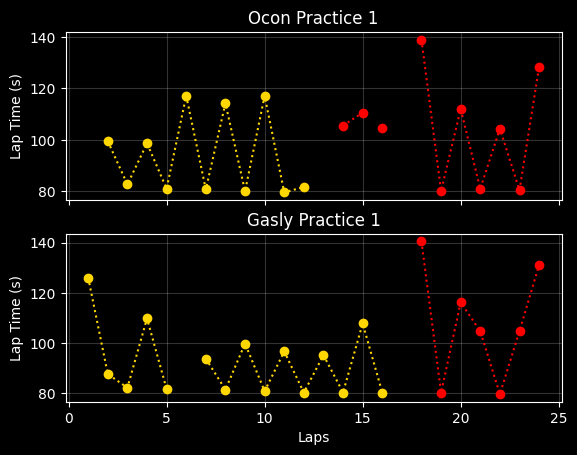

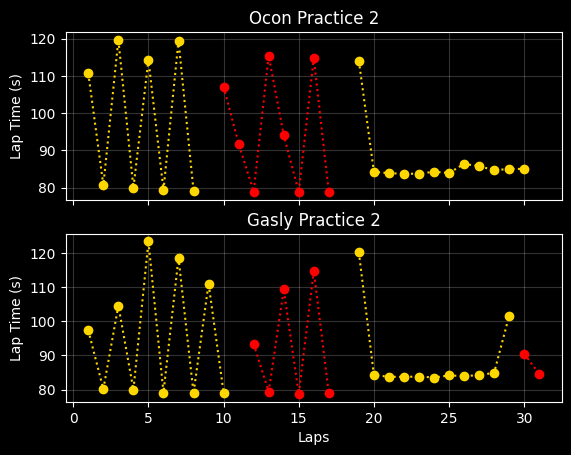

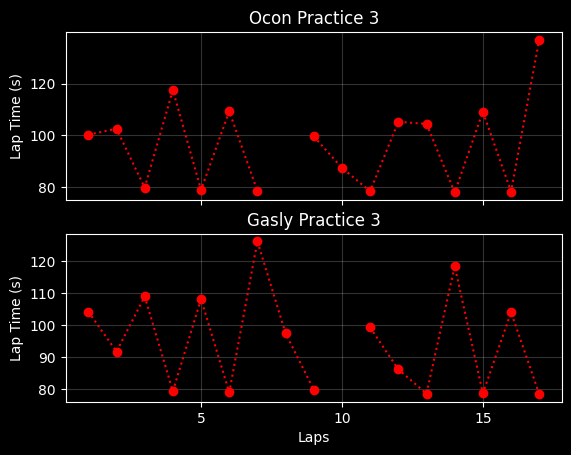

In [104]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1 = plot_testing(p1, 'OCO', ax = ax1, x_labels=False)
ax2 = plot_testing(p1, 'GAS', ax = ax2)
ax1.set_title("Ocon " + p1.name)
ax2.set_title("Gasly " + p1.name)
plt.savefig(directory_path + '/p1_comparison', bbox_inches = "tight")

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1 = plot_testing(p2, 'OCO', ax = ax1, x_labels=False)
ax2 = plot_testing(p2, 'GAS', ax = ax2)
ax1.set_title("Ocon " + p2.name)
ax2.set_title("Gasly " + p2.name)
plt.savefig(directory_path + '/p2_comparison', bbox_inches = "tight")

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1 = plot_testing(p3, 'OCO', ax = ax1, x_labels=False)
ax2 = plot_testing(p3, 'GAS', ax = ax2)
ax1.set_title("Ocon " + p3.name)
ax2.set_title("Gasly " + p3.name)
plt.savefig(directory_path + '/p3_comparison', bbox_inches = "tight")
#plt.legend()
#plt.title("Alpine drivers stints during " + p1.name)

In [105]:
limit = 1.15
p1_quick = p1.laps.pick_quicklaps(limit)
p1_quick['Session'] = 1
p2_quick = p2.laps.pick_quicklaps(limit)
p2_quick['Session'] = 2
p3_quick = p3.laps.pick_quicklaps(limit)
p3_quick['Session'] = 3
fp_laps = pd.concat([p1_quick, p2_quick, p3_quick])

In [132]:
fp_laps_ = fp_laps[fp_laps['Compound'].isin(ff1.plotting.COMPOUND_COLORS.keys())]
if fp_laps.shape != fp_laps_.shape:
    print("Warning deleted some laps because of nan compound")
fp_laps = fp_laps_

Warning delted some laps because of na compound


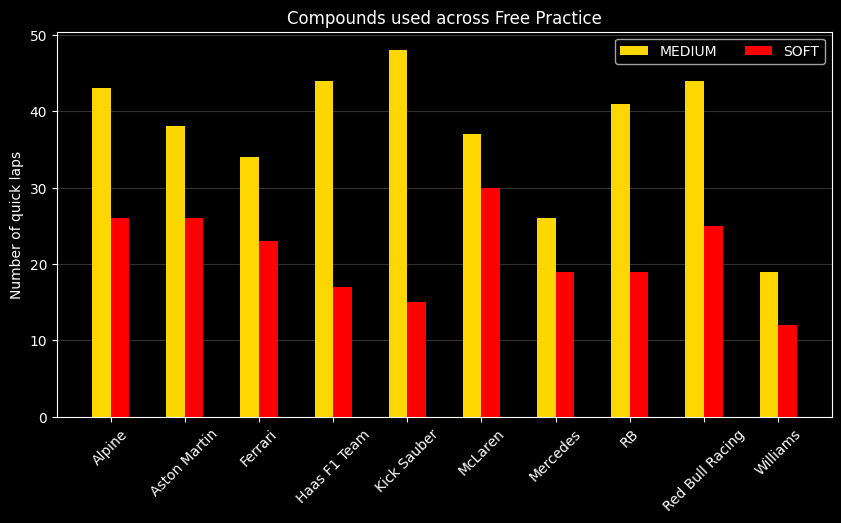

In [133]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming fp_laps is your DataFrame and compound_color is a function that returns colors

# Step 1: Convert the groupby size result to a DataFrame with teams as columns and compounds as rows
compounds_used_df = fp_laps.groupby(['Compound', 'Team']).size().unstack(fill_value=0)

# Make sure teams and compounds are sorted if needed
teams = sorted(compounds_used_df.columns)
compounds = sorted(compounds_used_df.index)

fig = plt.figure(figsize=(10, 5))
ax = plt.subplot()

x = np.arange(len(teams))
width = 0.25
pos = 0


# Iterate over compounds and plot bars for each team
for compound in compounds:
    # Here, we explicitly specify the height of each bar per team for the compound
    heights = [compounds_used_df.loc[compound, team] if compound in compounds_used_df.index and team in compounds_used_df.columns else 0 for team in teams]
    rects = ax.bar(x + width * pos, heights, width=width, label=compound, color=compound_color(compound), zorder=3)
    pos += 1

# Correct the way x-ticks are set
ax.set_xticks(x + width * (len(compounds) / 2 - 0.5))  # Adjust this to align ticks correctly
ax.set_xticklabels(teams, rotation=45)

ax.legend(loc='best', ncols=2)
ax.grid(zorder=0, axis='y', alpha=0.2)
plt.title('Compounds used across Free Practice')
plt.ylabel('Number of quick laps')
plt.savefig(directory_path + '/compounds', bbox_inches = "tight")
plt.show()


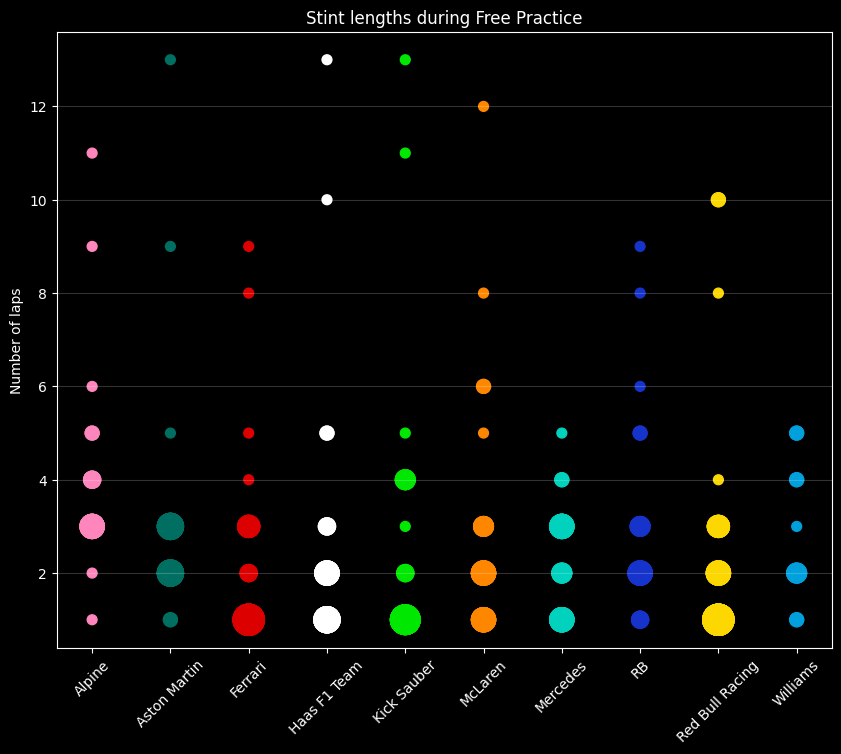

In [107]:
stint_length = pd.DataFrame(
    [(team, len(laps)) for (driver, team, stint, session), laps in fp_laps.groupby(['Driver', 'Team', 'Stint', 'Session'])],
    columns = ['Team', 'StintLength']
)

occurrences = stint_length.groupby(['Team', 'StintLength']).size().reset_index(name='Occurrences')
p1_stint_length = stint_length.merge(occurrences, how='left', on=['Team', 'StintLength'])

plt.figure(figsize=(10,8))
plt.xticks(rotation=45)
ax = plt.subplot()
ax.grid(axis='y', alpha=0.2, zorder=2)
for team, stint_len in p1_stint_length.groupby('Team'):
    ax.scatter(stint_len['Team'], stint_len['StintLength'], s=stint_len['Occurrences']*50, c=ff1.plotting.team_color(team.lower()))

plt.title('Stint lengths during Free Practice')
plt.ylabel('Number of laps')
plt.savefig(directory_path + '/stints', bbox_inches = "tight")
plt.show()

In [108]:
def plot_practice_run(compound, practice, session, min_laps = 4):
    return compare_long_runs_deg(session.laps[session.laps['Compound'] == compound.upper()], 'Practice ' + practice + ' Long runs (' + compound + ')', comparison_teams, min_laps=min_laps, file_name='p' + practice + '_' + compound)

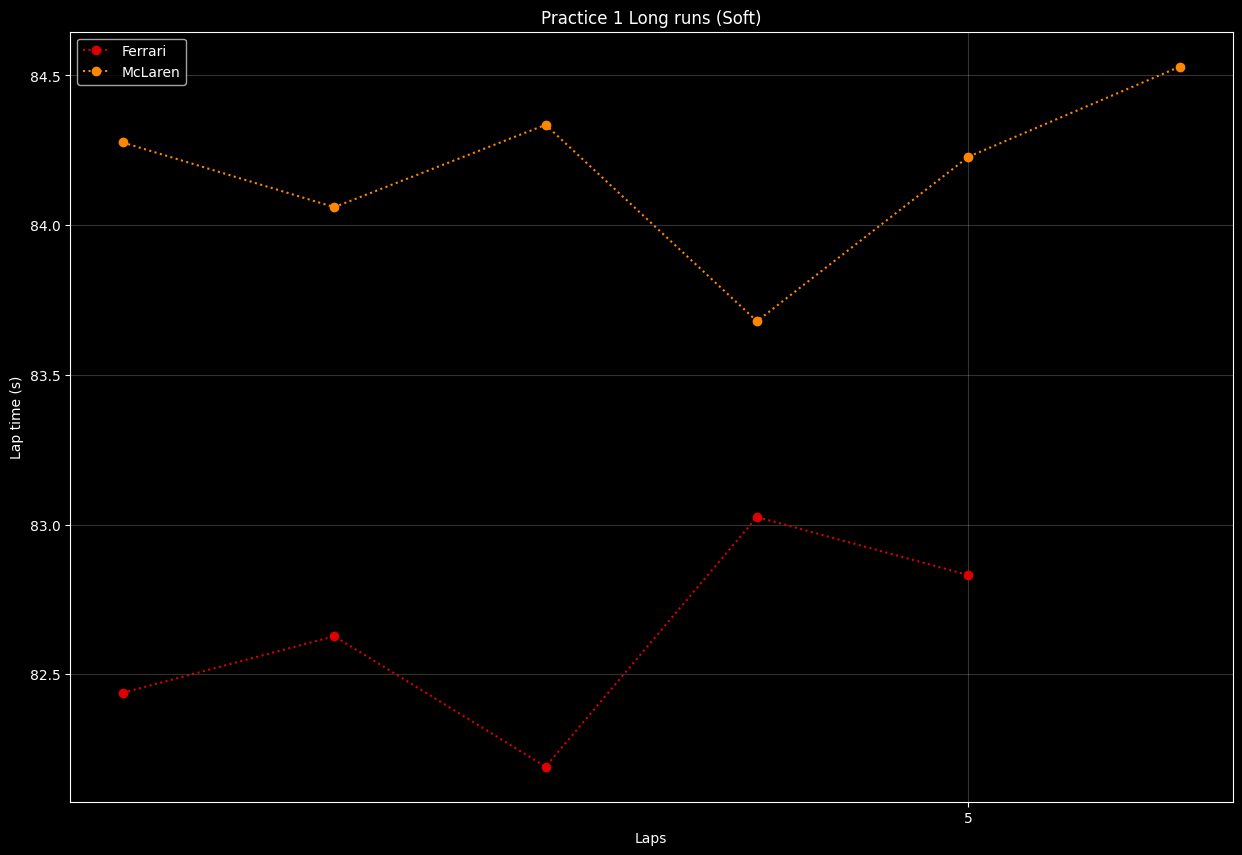

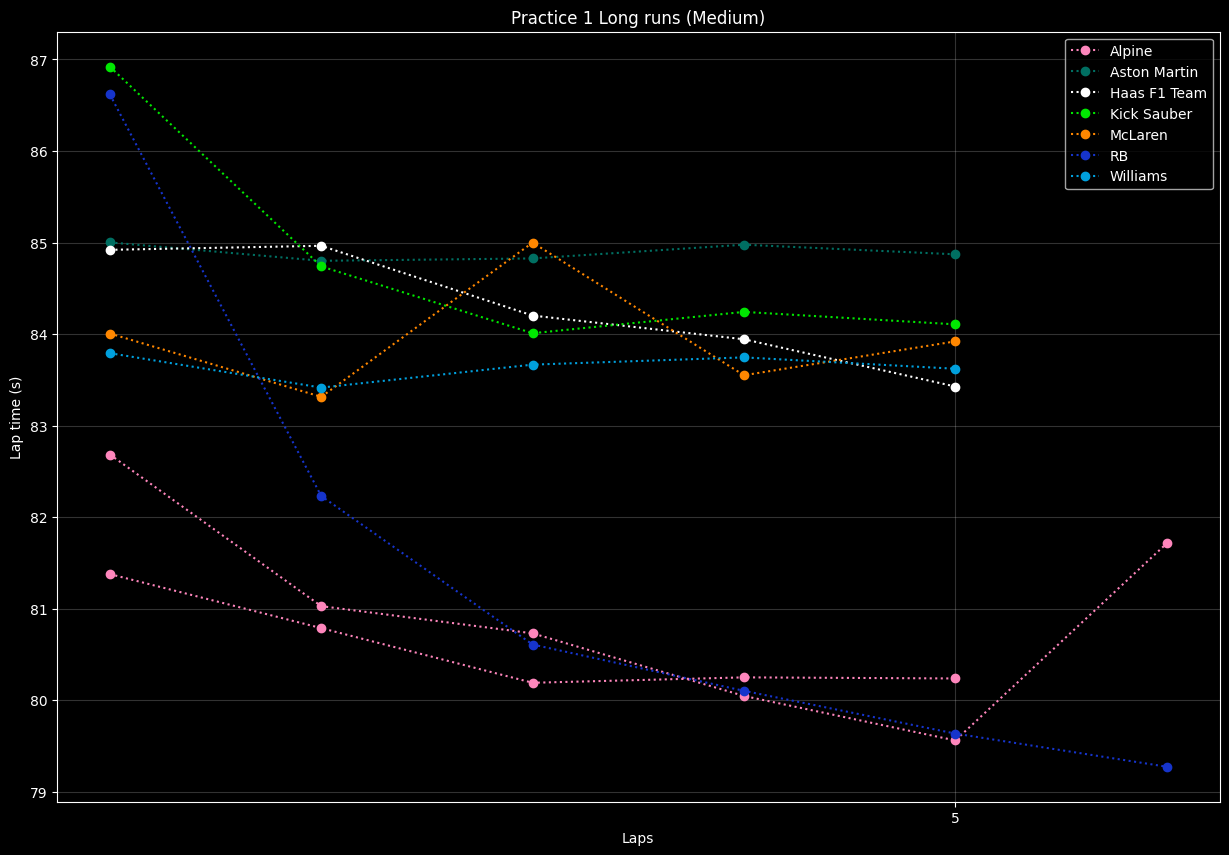

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


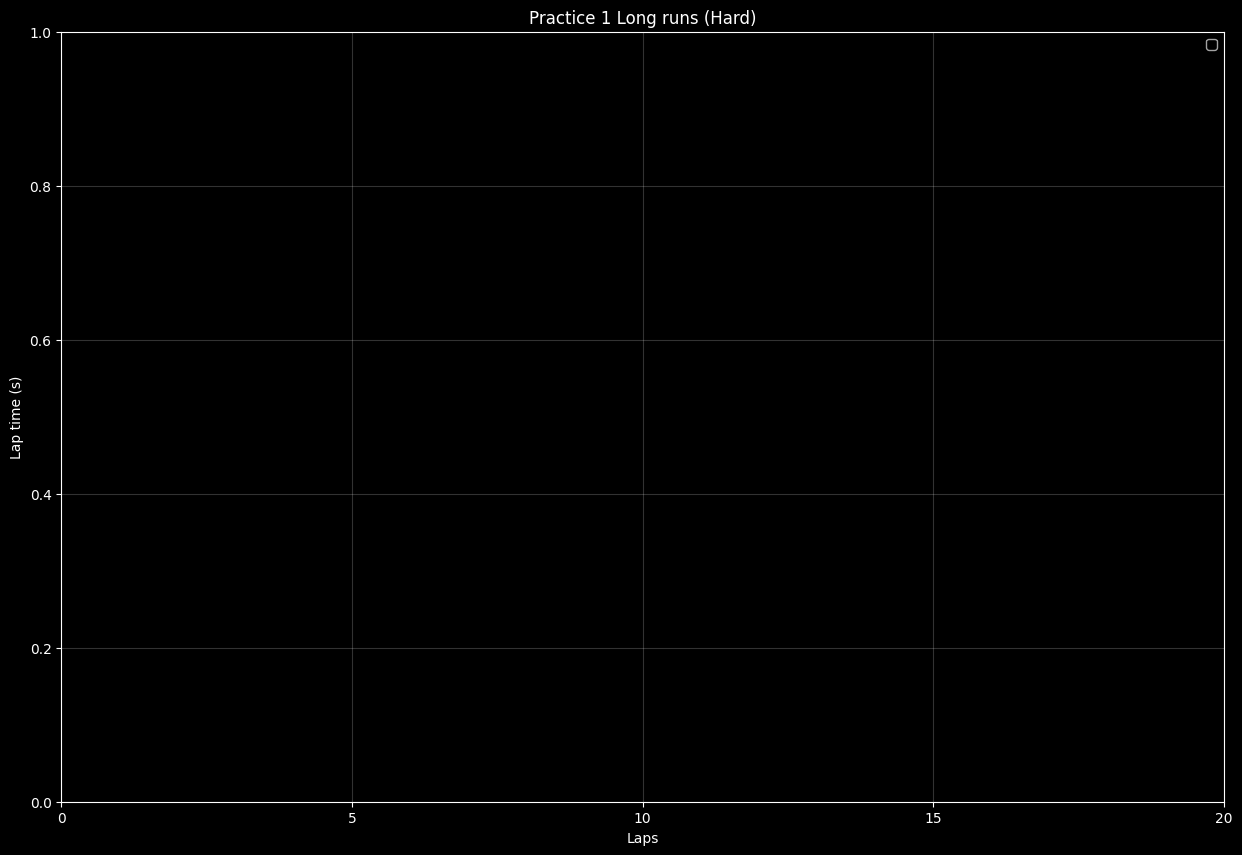

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


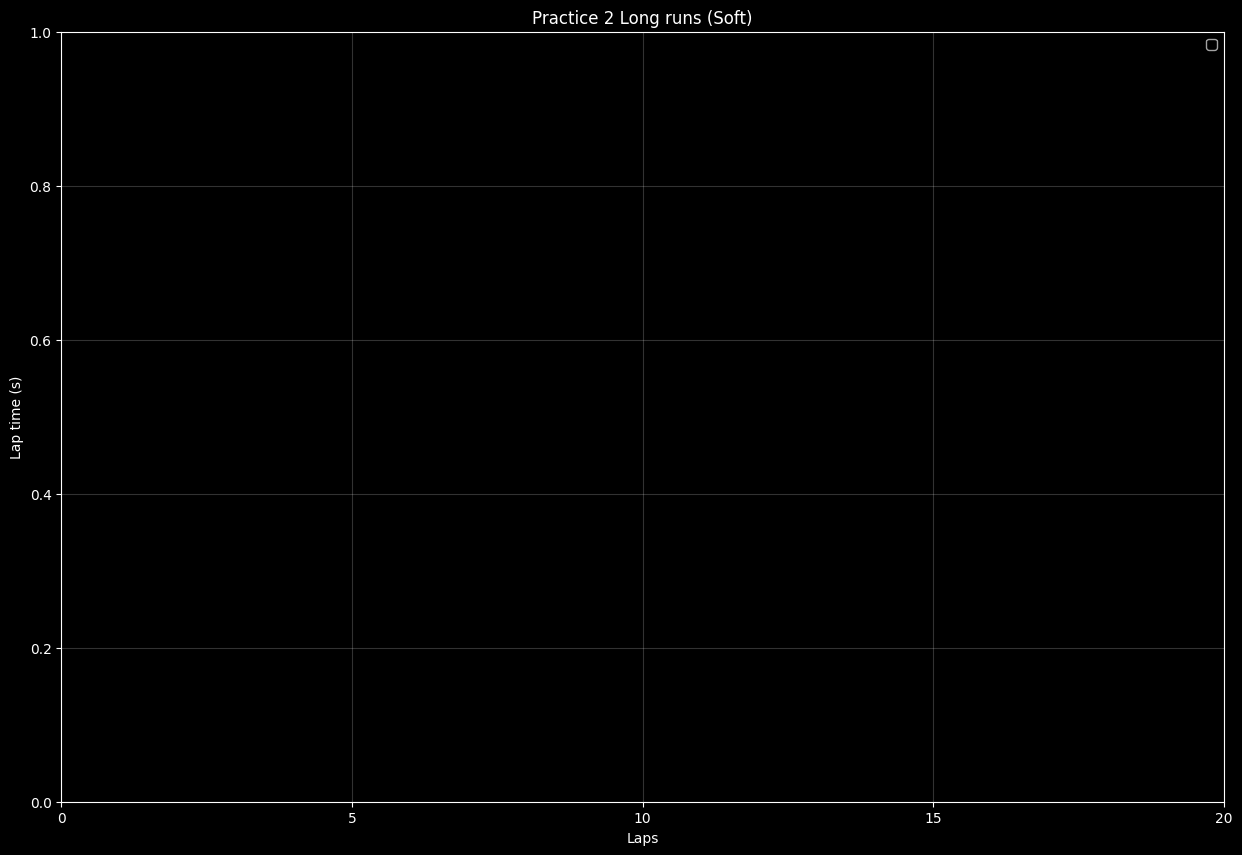

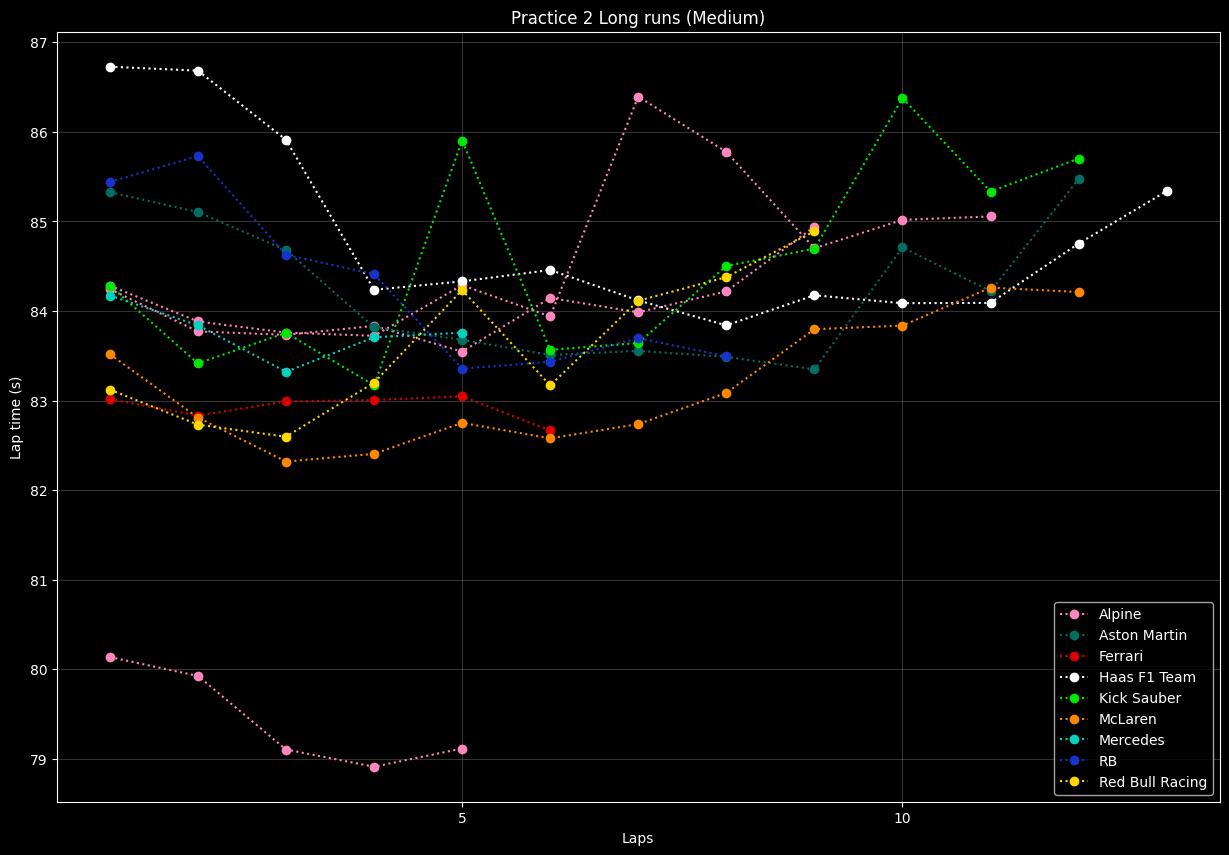

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


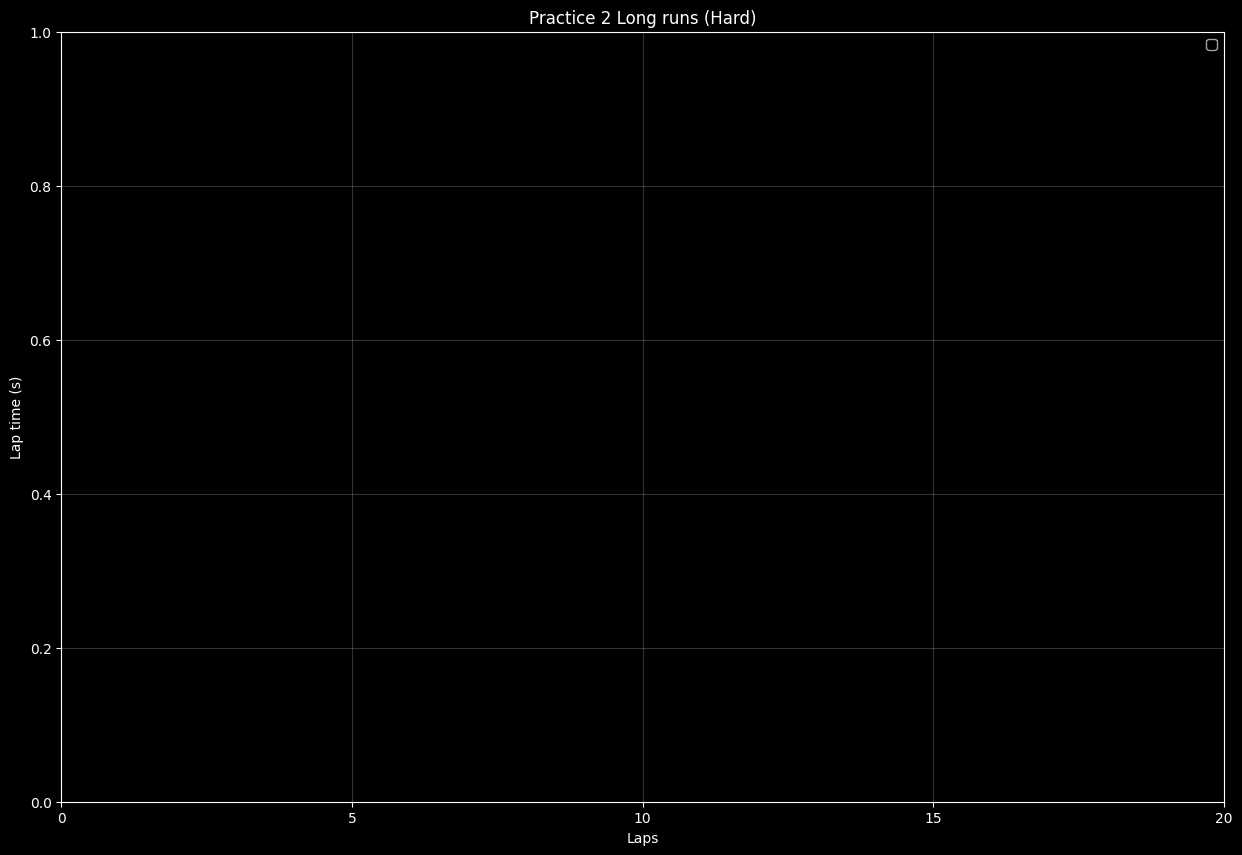

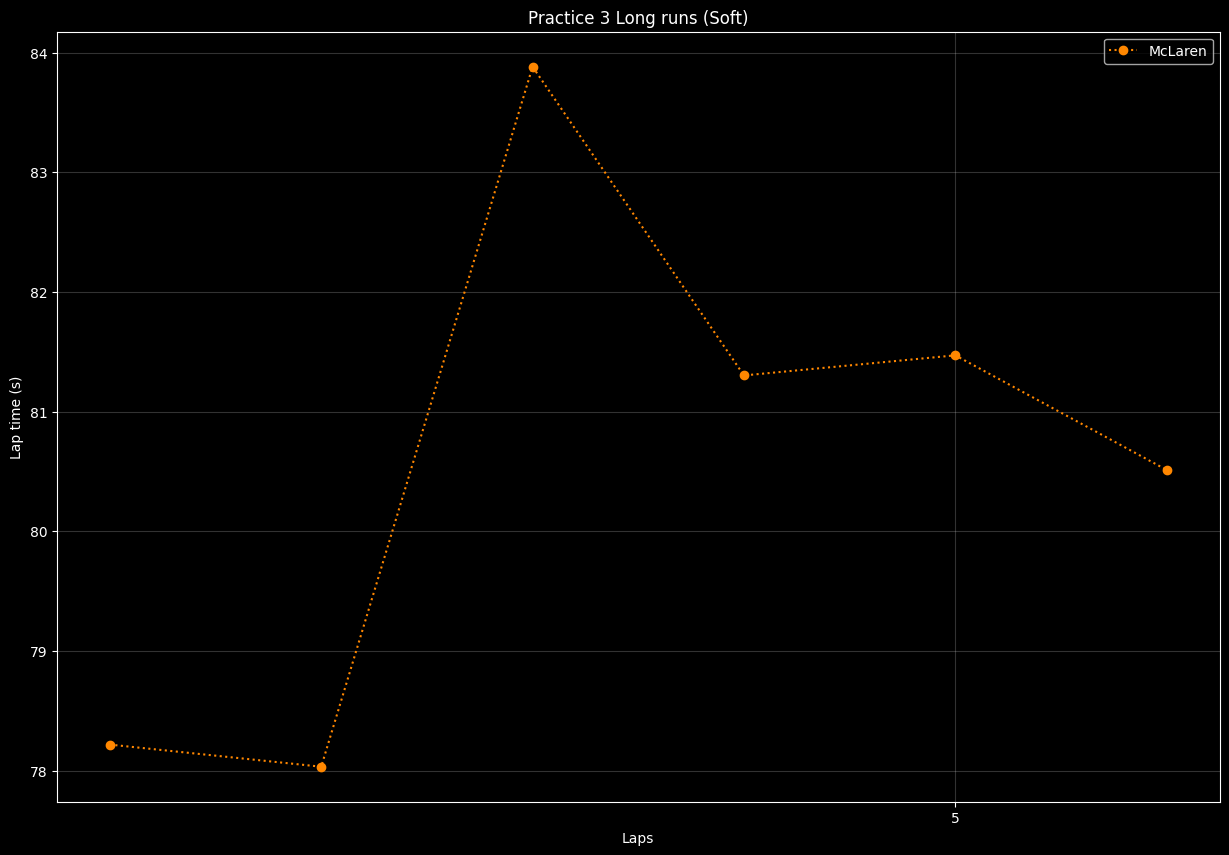

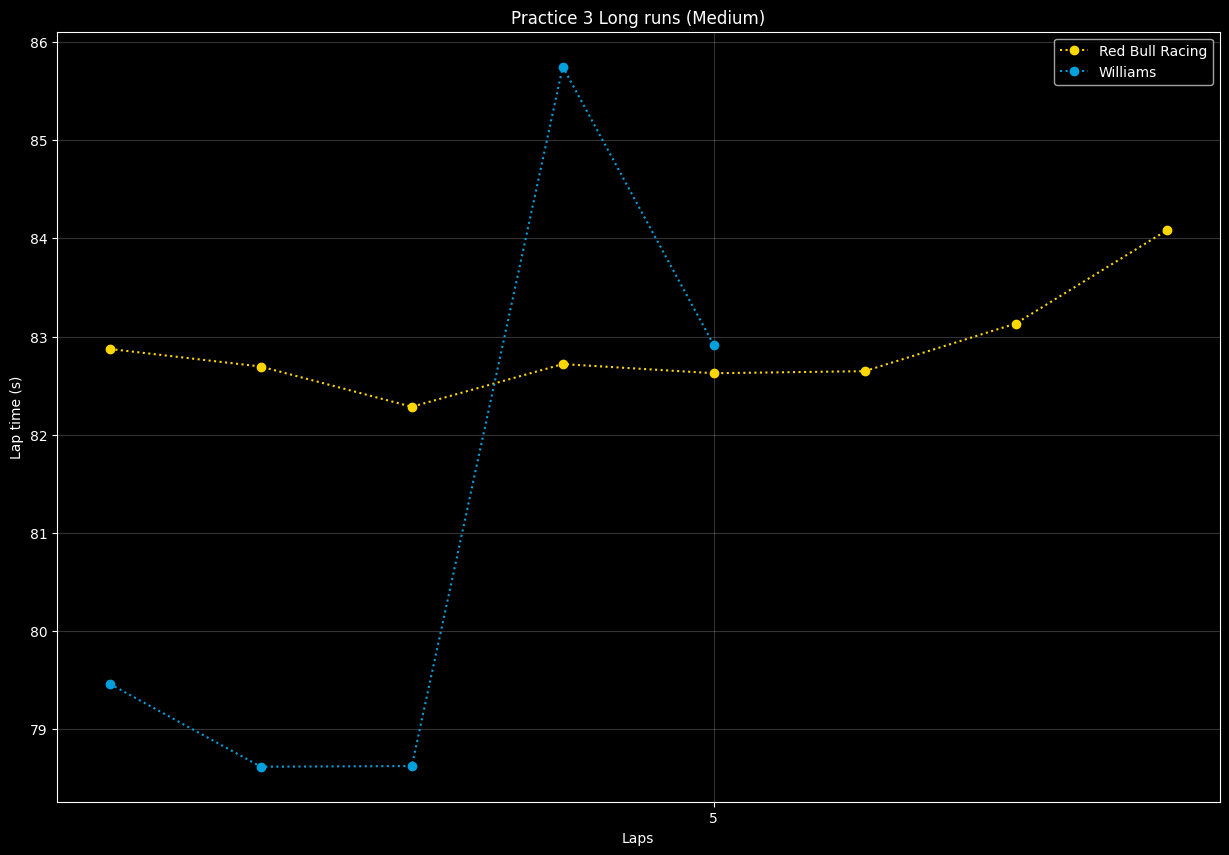

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


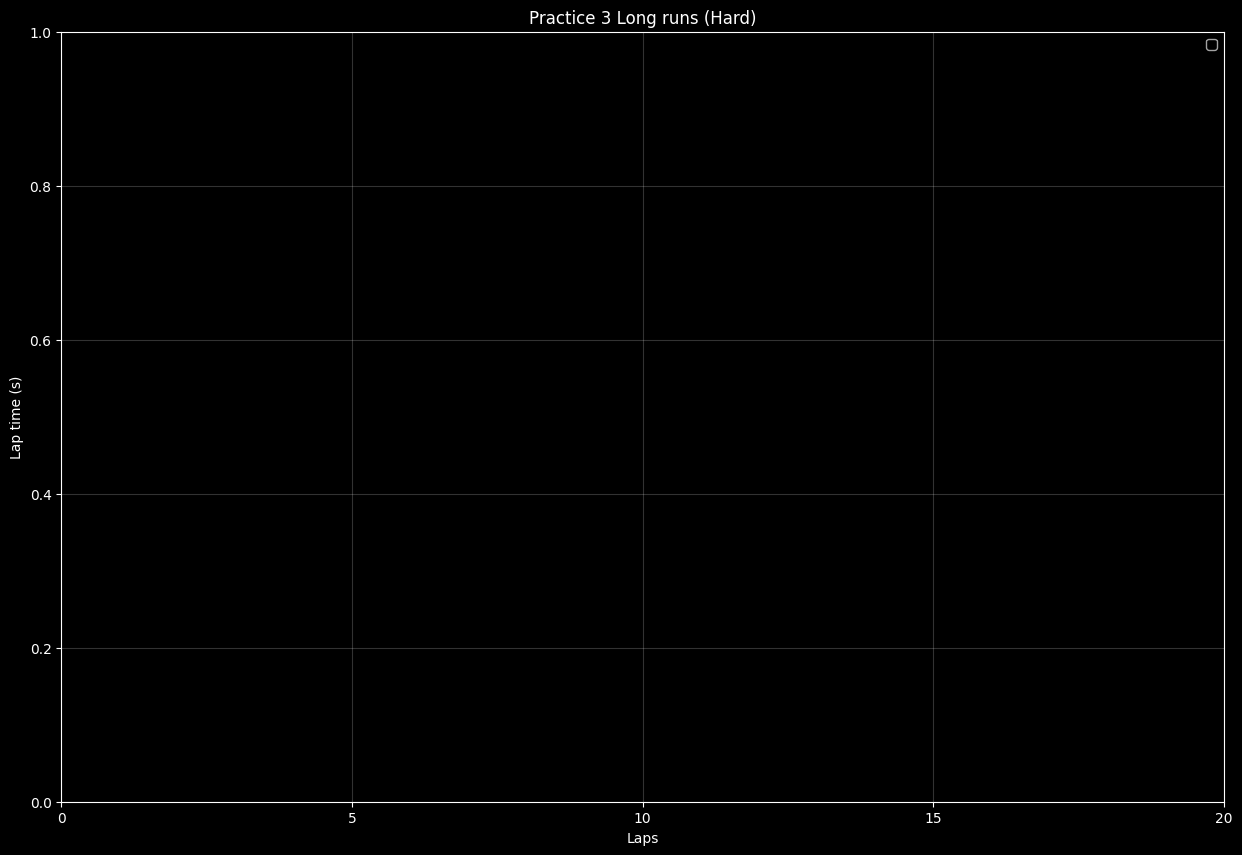

In [109]:
compounds = ['Soft', 'Medium', 'Hard']
practices = [('1', p1), ('2', p2), ('3', p3)]

for (practice, session) in practices:
    for compound in compounds:
        plot_practice_run(
            compound,
            practice,
            session
        )

In [110]:
#compare_long_runs_deg(p2.laps[p2.laps['Compound'] == 'SOFT'], 'Practice 2 Long runs (Softs)', comparison_teams, remove_outlier=False, file_name='p2_soft')

In [111]:
#compare_long_runs_deg(p1.laps[p1.laps['Compound'] == 'MEDIUM'], 'Practice 1 Long runs (Mediums)', comparison_teams, min_laps=4, file_name='p1_med')

In [112]:


#compare_long_runs_deg(p3.laps[p3.laps['Compound'] == 'HARD'], 'Day 3 Long runs (C1/C2)', comparison_teams, remove_outlier=True, file_name='p3_hard')
#compare_long_runs_deg(p2.laps[p2.laps['Compound'] == 'MEDIUM'], 'Day 2 Long runs (C3)', comparison_teams, remove_outlier=True, file_name='p2_med')
#compare_long_runs_deg(p1.laps[p1.laps['Compound'] == 'MEDIUM'], 'Day 1 Long runs (C3)', comparison_teams, remove_outlier=True, file_name='p3_med')
#compare_long_runs_deg(p3.laps[p3.laps['Compound'] == 'MEDIUM'], 'Day 3 Long runs (C3)', comparison_teams, remove_outlier=True, file_name='p3_med')
#compare_long_runs_deg(p3.laps[p3.laps['Compound'] == 'MEDIUM'], 'Day 3 Long runs (C3)', comparison_teams, remove_outlier=True, file_name='p3_med')
